In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import control 
from scipy.optimize import brentq
import sys



In [3]:
class MyNN(nn.Module):
    #do variable length hidden layers
    #output and input layer do not have activation functions
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super(MyNN, self).__init__()
        layers = []
        for i in range(num_hidden_layers):
            in_features = input_size if i == 0 else hidden_size
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)



In [4]:
#Easy control system
def lyapunov(x):
    return 0.5 * (x - 1)**2
def f(x): #x dot
    return 1-x

def train_model(x_train, y_train, model, num_epochs=1000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

MyNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)
Epoch [100/1000], Loss: 0.0232
Epoch [200/1000], Loss: 0.0231
Epoch [300/1000], Loss: 0.0231
Epoch [400/1000], Loss: 0.0231
Epoch [500/1000], Loss: 0.0231
Epoch [600/1000], Loss: 0.0231
Epoch [700/1000], Loss: 0.0231
Epoch [800/1000], Loss: 0.0231
Epoch [900/1000], Loss: 0.0231
Epoch [1000/1000], Loss: 0.0231


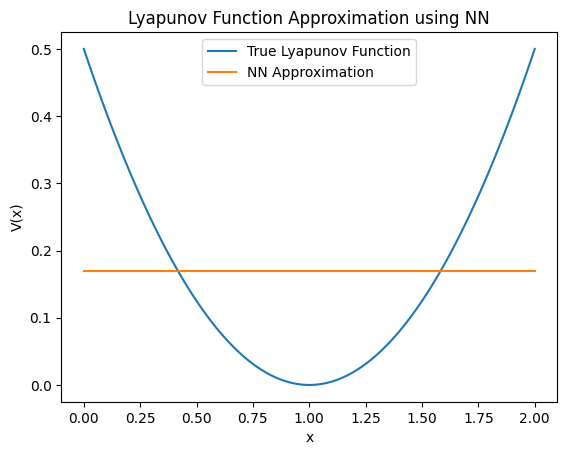

In [5]:
#1-2-1 nn with ReLU activations and 2 n in hidden
one_two_one_nn = MyNN(input_size=1, num_hidden_layers=1, hidden_size=4, output_size=1)
print(one_two_one_nn)
#can this approximate a lyapunov function for a simple system?
#i.e. \dot{x} = f(x) = 
# V(x) = 1/2 (x - 1)^2
#train to approximate V
#get training data
x_train = torch.linspace(0, 2, steps=100).view(-1, 1)
y_train = lyapunov(x_train).view(-1, 1)
#train nn
one_two_one_nn = train_model(x_train, y_train, one_two_one_nn, num_epochs=1000, learning_rate=0.01)


#compare the function vs the nn approximation
x_test = torch.linspace(0, 2, steps=100).view(-1, 1)
y_test = lyapunov(x_test).view(-1, 1)
y_nn = one_two_one_nn(x_test).detach().numpy()
plt.plot(x_test.numpy(), y_test.numpy(), label='True Lyapunov Function')
plt.plot(x_test.numpy(), y_nn, label='NN Approximation')
plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Lyapunov Function Approximation using NN')
plt.show()

/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_96518/1340099131.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V_grad = float(np.dot(vec_2.T, vec_1))


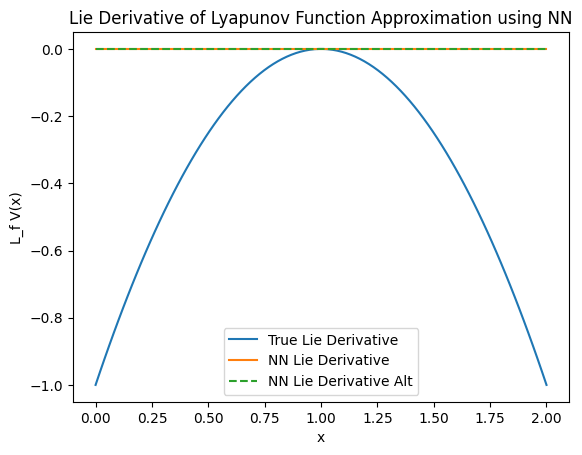

In [6]:
#plot the lie derivative of the true lyapunov function vs the nn approximation
def lie_derivative_nn(x, V, f):
    V_grad = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    return V_grad * f(x) 

def lie_derivative_true(x):
    V_grad = x - 1
    return V_grad * f(x)

def step_function(x):
    if x >= 0:
        return 1
    else:
        return 0

def V_dot(x, model): #the dot product form I derived in my notes
    hidden_linear = model.network[0]
    output_linear = model.network[2]
    n = hidden_linear.out_features
    vec_1 = np.zeros((n, 1))
    vec_2 = np.zeros((n, 1))
    for i in range(n):
        w1 = hidden_linear.weight[i, 0].item()
        b1 = hidden_linear.bias[i].item()
        w2 = output_linear.weight[0, i].item()
        vec_1[i] = step_function(w1 * x + b1)
        vec_2[i] = w1 * w2
    V_grad = float(np.dot(vec_2.T, vec_1))
    return V_grad * f(x)

y_lie_true = lie_derivative_true(x_test).view(-1, 1).detach().numpy()
x_test.requires_grad = True
y_nn = one_two_one_nn(x_test)
y_lie_nn = lie_derivative_nn(x_test, y_nn, f).view(-1, 1).detach().numpy()
#also plot alternative V_dot to make sure they are the same
y_lie_nn_alt = np.zeros_like(y_lie_nn)
x_test_floats = x_test.detach().numpy().flatten()
for i in range(x_test.shape[0]):
    y_lie_nn_alt[i] = V_dot(float(x_test_floats[i]), one_two_one_nn)
#check they are the same
plt.figure()
plt.plot(x_test.detach().numpy(), y_lie_true, label='True Lie Derivative')
plt.plot(x_test.detach().numpy(), y_lie_nn, label='NN Lie Derivative')
plt.plot(x_test.detach().numpy(), y_lie_nn_alt, label='NN Lie Derivative Alt', linestyle='dashed')
plt.legend()
plt.xlabel('x')
plt.ylabel('L_f V(x)')
plt.title('Lie Derivative of Lyapunov Function Approximation using NN')
plt.show()

In [7]:

# print(one_two_one_nn.network[0].weight)
# print(one_two_one_nn.network[2].weight)
# print(torch.Tensor([[1], [2]]))
#print the weights and biases
print(one_two_one_nn.network)
print("Weights and biases of the trained NN:")
print(one_two_one_nn.network[0].weight)
print(one_two_one_nn.network[0].bias)
print(one_two_one_nn.network[1])  # This will print the ReLU layer
print(one_two_one_nn.network[2].weight)
print(one_two_one_nn.network[2].bias)

Sequential(
  (0): Linear(in_features=1, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
)
Weights and biases of the trained NN:
Parameter containing:
tensor([[-0.3066],
        [ 0.2991],
        [ 0.8121],
        [-0.1284]], requires_grad=True)
Parameter containing:
tensor([-0.0290,  0.9592,  0.0057, -0.9712], requires_grad=True)
ReLU()
Parameter containing:
tensor([[ 0.3916,  0.3185, -0.1173,  0.2101]], requires_grad=True)
Parameter containing:
tensor([-0.1348], requires_grad=True)


In [8]:
#takes in model, num of input neurons, num of hidden neurons, and list of functions that represent dynamical system
#outputs v dot at some x
def my_result(model, input_num, hidden_num, F_func_list, x_state):
    #first collect the edges into appropriate matrices to access
    W_matrix  = model.network[0].weight.detach().numpy().T #each column is weights into a hidden neuron [w1, w2,..., wn; w_n+1, ...]
    B_vector  = model.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
    W_out_vec = model.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
    #W_out_vec = W_out_vec[::-1]
    W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
    #compute activation vector at x_state: This is a stationary vector for any x_state
    A_vector = np.zeros((hidden_num, 1))
    for i in range(hidden_num):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        A_vector[i] = step_function(np.dot(w_i, x_state) + b_i)
    
    #now loop through each function in F_func_list and multiply by the dot product form
    sum = 0
    for i in range(input_num):
        F_i = F_func_list[i]
        f_i_x = F_i(x_state)
        #compute V_dot contribution from this f_i
        this_w_vec = W_out_matrix @ W_matrix[i, :].reshape(-1, 1)
        sum = sum + f_i_x * np.dot(A_vector.T, this_w_vec)
    return sum






Epoch [100/5000], Loss: 0.0043
Epoch [200/5000], Loss: 0.0014
Epoch [300/5000], Loss: 0.0006
Epoch [400/5000], Loss: 0.0004
Epoch [500/5000], Loss: 0.0003
Epoch [600/5000], Loss: 0.0002
Epoch [700/5000], Loss: 0.0002
Epoch [800/5000], Loss: 0.0001
Epoch [900/5000], Loss: 0.0001
Epoch [1000/5000], Loss: 0.0001
Epoch [1100/5000], Loss: 0.0001
Epoch [1200/5000], Loss: 0.0001
Epoch [1300/5000], Loss: 0.0001
Epoch [1400/5000], Loss: 0.0001
Epoch [1500/5000], Loss: 0.0001
Epoch [1600/5000], Loss: 0.0001
Epoch [1700/5000], Loss: 0.0001
Epoch [1800/5000], Loss: 0.0001
Epoch [1900/5000], Loss: 0.0001
Epoch [2000/5000], Loss: 0.0001
Epoch [2100/5000], Loss: 0.0001
Epoch [2200/5000], Loss: 0.0001
Epoch [2300/5000], Loss: 0.0001
Epoch [2400/5000], Loss: 0.0000
Epoch [2500/5000], Loss: 0.0000
Epoch [2600/5000], Loss: 0.0000
Epoch [2700/5000], Loss: 0.0000
Epoch [2800/5000], Loss: 0.0000
Epoch [2900/5000], Loss: 0.0000
Epoch [3000/5000], Loss: 0.0000
Epoch [3100/5000], Loss: 0.0000
Epoch [3200/5000]

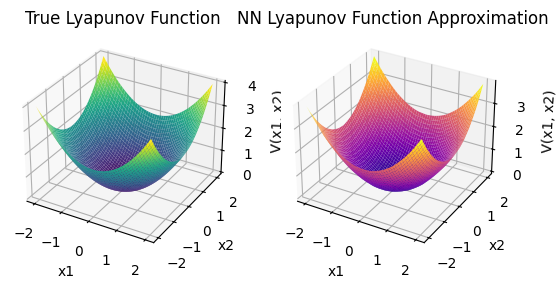

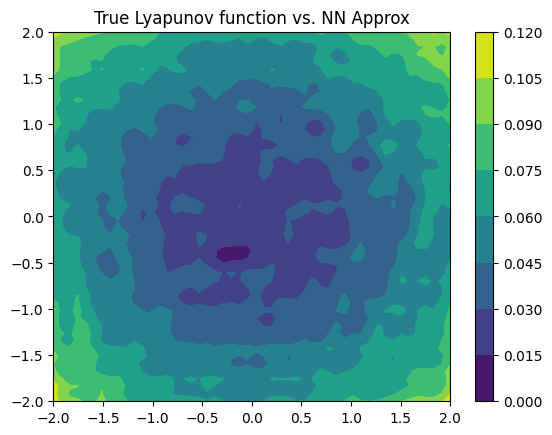

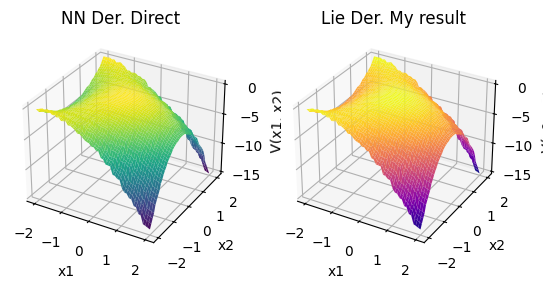

Text(0.5, 1.0, 'Torch Lie vs. My Lie')

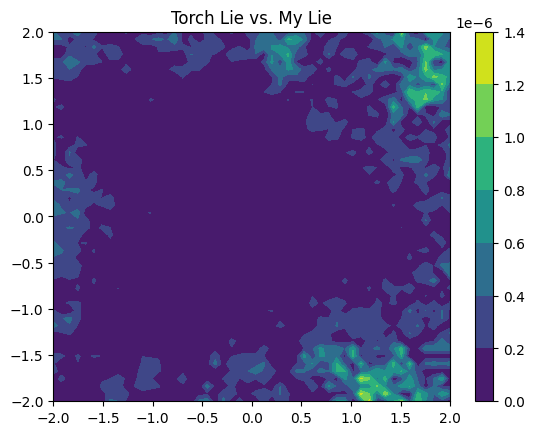

In [9]:
#a dynamical system to test out
def f_1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -x1 - x2**2
def f_2(x):
    x2 = x[1, 0]
    return -x2

def V_analytic(x1, x2):
    return 0.5 * (x1**2 + x2**2)
#caluclate the lie derivative with the gradients in torch
def torch_lie_derivative(f_1, f_2, x):
    V_grad = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    
#now approximate the lyapunov function with a nn
two_n_one_nn = MyNN(input_size=2, num_hidden_layers=1, hidden_size=100, output_size=1)
x1_train = torch.linspace(-2, 2, steps=50)
x2_train = torch.linspace(-2, 2, steps=50)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = V_analytic(x_train_2d[:,0], x_train_2d[:,1]).view(-1, 1)
#train nn
two_n_one_nn = train_model(x_train_2d, y_train_2d, two_n_one_nn, num_epochs=5000, learning_rate=0.01)

#plot the true vs nn lyapunov function on a grid
x1_test = torch.linspace(-2, 2, steps=50)
x2_test = torch.linspace(-2, 2, steps=50)
x1_grid_test, x2_grid_test = torch.meshgrid(x1_test, x2_test, indexing='ij')
x_test_2d = torch.stack([x1_grid_test.flatten(), x2_grid_test.flatten()], dim=1)
y_test_2d = V_analytic(x_test_2d[:,0], x_test_2d[:,1]).view(-1, 1)
y_nn_2d = two_n_one_nn(x_test_2d).detach().numpy()
#reshape for plotting
y_test_2d = y_test_2d.view(50, 50).detach().numpy()
y_nn_2d = y_nn_2d.reshape(50, 50)

#plot both on the same plot in 3d but different styles
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_test_2d, cmap='viridis')
ax.set_title('True Lyapunov Function')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('V(x1, x2)')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_nn_2d, cmap='plasma')
ax2.set_title('NN Lyapunov Function Approximation')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('V(x1, x2)')
plt.show()  

#also plot the error between the two
fig = plt.figure()
errors = np.abs(y_test_2d - y_nn_2d)
cp = plt.contourf(x1_grid_test.numpy(), x2_grid_test.numpy(), errors)
cb = plt.colorbar(cp)
plt.title("True Lyapunov function vs. NN Approx")


#now plot the lie derivative of both
F_func_list = [f_1, f_2]
y_lie_nn_grad_2d = np.zeros((50, 50))
y_lie_my_result = np.zeros((50, 50))
for i in range(50):
    for j in range(50):
        x_state = x_test_2d[i*50 + j].unsqueeze(0).clone().detach().requires_grad_(True)
        
        # Get the NN output and compute gradient
        V_nn = two_n_one_nn(x_state)
        V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
        
        # Evaluate the dynamical system at this point
        x_state_flat = x_state.detach().squeeze(0).unsqueeze(1)
        f_1_val = f_1(x_state_flat)
        f_2_val = f_2(x_state_flat)
        
        # Compute Lie derivative: grad(V) · f(x)
        lie_deriv = V_grad[0, 0] * f_1_val + V_grad[0, 1] * f_2_val
        y_lie_nn_grad_2d[i, j] = lie_deriv.item()

        #also compute using my_result function for verification
        y_lie_my_result[i, j] = my_result(two_n_one_nn, 2, 100, F_func_list, x_state_flat)
        

#plot both lie derivatives to compare in 3d
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_lie_nn_grad_2d, cmap='viridis')
ax.set_title('NN Der. Direct ')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('V(x1, x2)')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_lie_my_result, cmap='plasma')
ax2.set_title('Lie Der. My result')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('V(x1, x2)')
plt.show()  



#also plot the error between the two
fig = plt.figure()
errors_lie = np.abs(y_lie_my_result - y_lie_nn_grad_2d)
cp = plt.contourf(x1_grid_test.numpy(), x2_grid_test.numpy(), errors_lie)
cb = plt.colorbar(cp)
plt.title("Torch Lie vs. My Lie")


In [10]:
print("weights and biases of the trained 2-4-1 NN:")
print(two_n_one_nn.network)
print("Weights and biases of the trained NN:")
print(two_n_one_nn.network[0].weight)

print(two_n_one_nn.network[0].bias)
print(two_n_one_nn.network[1])  # This will print the ReLU layer
print(two_n_one_nn.network[2].weight)
print(two_n_one_nn.network[2].bias) 

weights and biases of the trained 2-4-1 NN:
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
Weights and biases of the trained NN:
Parameter containing:
tensor([[ 7.9148e-01, -1.4951e-01],
        [-1.4715e-01, -2.0827e-01],
        [ 2.5417e-01, -6.3627e-01],
        [-5.5874e-01,  5.7280e-01],
        [-4.7513e-01,  2.7353e-01],
        [ 6.3963e-01, -1.7221e-02],
        [ 2.1105e-02, -7.8305e-01],
        [-2.4691e-02,  2.7840e-01],
        [ 6.9762e-02,  4.2436e-01],
        [ 4.7639e-01, -1.8950e-01],
        [-2.3525e-01,  4.1631e-01],
        [-4.3555e-01,  3.1339e-01],
        [-3.9132e-01,  5.3096e-01],
        [-6.7599e-01, -2.2023e-01],
        [ 4.6311e-02,  6.3550e-01],
        [-5.9651e-01, -4.3550e-01],
        [ 3.1852e-01,  4.1273e-01],
        [ 2.4110e-01, -5.5791e-01],
        [-2.7869e-01,  1.9010e-01],
        [-8.0925e-02, -7.2035e-01],
        [-6.0792e-01, -1.6483e-0

In [11]:
#make numpy matrix
print(two_n_one_nn.network[2].weight.detach().numpy().T)
print(np.diag(two_n_one_nn.network[2].weight.detach().numpy().flatten()))

[[ 0.17631386]
 [-0.03806103]
 [ 0.05649699]
 [ 0.04245701]
 [-0.03107986]
 [ 0.327343  ]
 [ 0.35664138]
 [-0.091553  ]
 [ 0.19352494]
 [ 0.3765222 ]
 [ 0.01067066]
 [ 0.0476052 ]
 [ 0.20128918]
 [ 0.08660404]
 [ 0.21007761]
 [ 0.06565007]
 [ 0.29039645]
 [ 0.05610571]
 [ 0.09749076]
 [ 0.08781435]
 [ 0.15261444]
 [ 0.28765622]
 [ 0.01058646]
 [ 0.1260668 ]
 [ 0.32316014]
 [ 0.03813177]
 [ 0.14914821]
 [ 0.19642623]
 [ 0.2287568 ]
 [-0.02198985]
 [ 0.34600937]
 [ 0.12917393]
 [ 0.17920302]
 [ 0.04469571]
 [-0.04222235]
 [ 0.31386733]
 [ 0.1684348 ]
 [ 0.12333927]
 [ 0.04057422]
 [ 0.04350923]
 [ 0.38325512]
 [ 0.14707279]
 [ 0.09414832]
 [ 0.16039011]
 [ 0.45498616]
 [ 0.02452786]
 [-0.01793948]
 [ 0.10452121]
 [ 0.04773538]
 [ 0.23851494]
 [ 0.360214  ]
 [ 0.07346383]
 [ 0.01058084]
 [ 0.01014253]
 [ 0.10857956]
 [ 0.0730869 ]
 [-0.06987257]
 [ 0.19373153]
 [ 0.41394928]
 [ 0.2234987 ]
 [ 0.21123157]
 [ 0.15220273]
 [ 0.40953752]
 [ 0.12511723]
 [ 0.19086333]
 [ 0.16700058]
 [ 0.11033

Simple Example in $\mathbb{R}^2$

Simple NN Epoch [100/1000], Loss: 0.0902
Simple NN Epoch [200/1000], Loss: 0.0890
Simple NN Epoch [300/1000], Loss: 0.0890
Simple NN Epoch [400/1000], Loss: 0.0890
Simple NN Epoch [500/1000], Loss: 0.0890
Simple NN Epoch [600/1000], Loss: 0.0890
Simple NN Epoch [700/1000], Loss: 0.0890
Simple NN Epoch [800/1000], Loss: 0.0890
Simple NN Epoch [900/1000], Loss: 0.0890
Simple NN Epoch [1000/1000], Loss: 0.0890


/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_96518/1957142679.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x_vec.T @ P @ x_vec)


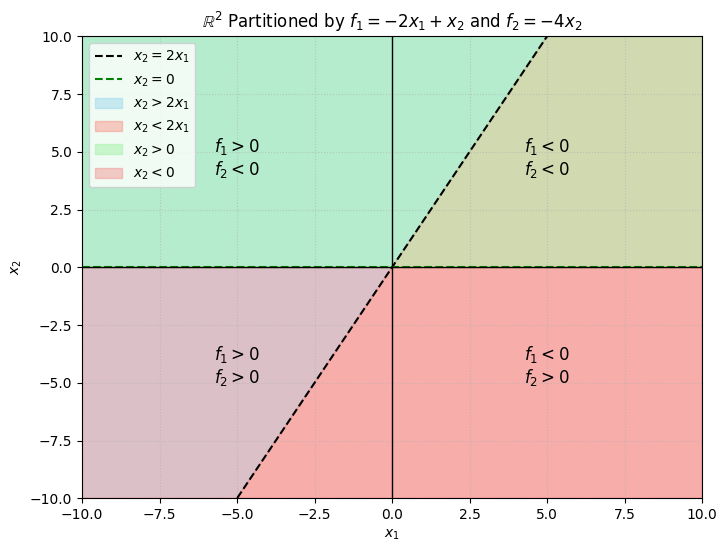

In [12]:

def simple_f1(x1, x2):
    return -2*x1 + x2
def simple_f2(x1, x2):
    return -4*x2

#build and train a simple nn, 2- 2- 1
simple_nn = MyNN(input_size=2, num_hidden_layers=1, hidden_size=2, output_size=1)
A = np.array([[-2, 1], [0, -4]])
Q = np.eye(2)
P = control.lyap(A.T, Q) #this is the P for V = x^T P x
#use P to make training data
def V_linear(x1, x2):
    x_vec = np.array([[x1], [x2]])
    return float(x_vec.T @ P @ x_vec)

#train nn
x1_train = torch.linspace(-2, 2, steps=50)
x2_train = torch.linspace(-2, 2, steps=50)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([V_linear(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
criterion_simple = nn.MSELoss()
optimizer_simple = torch.optim.Adam(simple_nn.parameters(), lr=0.01)
num_epochs_simple = 1000
for epoch in range(num_epochs_simple):
    optimizer_simple.zero_grad()
    outputs_simple = simple_nn(x_train_2d)
    loss_simple = criterion_simple(outputs_simple, y_train_2d)
    loss_simple.backward()
    optimizer_simple.step()
    if (epoch+1) % 100 == 0:
        print(f'Simple NN Epoch [{epoch+1}/{num_epochs_simple}], Loss: {loss_simple.item():.4f}')



#plot the positive and negative regions for f_1 and f_2

# 1. Setup the data
x1 = np.linspace(-10, 10, 100)
x2_boundary = 2*x1
f2_boundary = 0
# 2. Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# 3. Plot the boundary line (Dashed indicates strict inequality)
ax.plot(x1, x2_boundary, color='black', linestyle='--', linewidth=1.5, label='$x_2 = 2x_1$')
ax.plot(x1, f2_boundary * np.ones_like(x1), color='green', linestyle='--', linewidth=1.5, label='$x_2 = 0$')

ax.fill_between(x1, x2_boundary, 10, color='skyblue', alpha=0.4, label='$x_2 > 2x_1$')
ax.fill_between(x1, x2_boundary, -10, color='salmon', alpha=0.4, label='$x_2 < 2x_1$')
ax.fill_between(x1, f2_boundary, 10, color='lightgreen', alpha=0.4, label='$x_2 > 0$')
ax.fill_between(x1, f2_boundary, -10, color='lightcoral', alpha=0.4, label='$x_2 < 0$')

# Place text at a specific coordinate
ax.text(-5, 5, "$f_1 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, 4, "$f_2 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 5, "$f_1 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 4, "$f_2 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, -4, "$f_1 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, -5, "$f_2 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, -4, "$f_1 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, -5, "$f_2 > 0 $", fontsize=12, fontweight='bold', ha='center')

# 6. Formatting the plot
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axhline(0, color='black', lw=1) # X-axis line
ax.axvline(0, color='black', lw=1) # Y-axis line
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$\mathbb{R}^2$ Partitioned by $f_1 = -2x_1 + x_2$ and $f_2 = -4x_2$')

# 7. Add the legend
ax.legend(loc='upper left', frameon=True)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()





The Neurons in the Hidden Layer also Partition the State Space

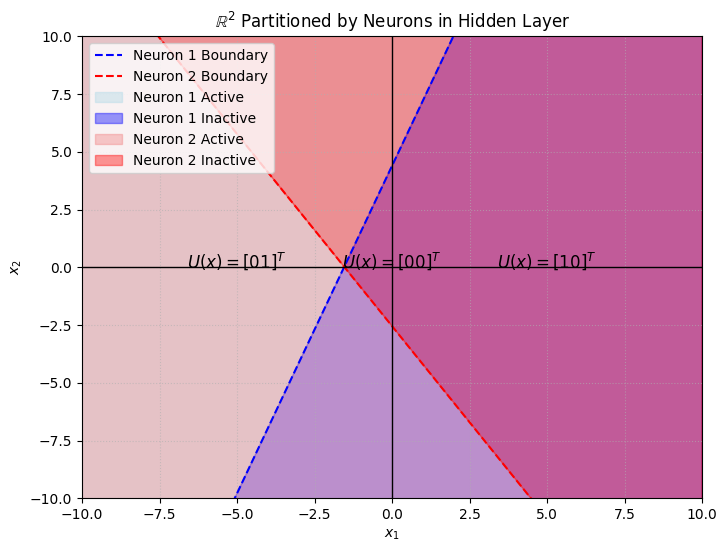

In [13]:
#Okay now we need to plot the regions of U(x), where 
W_matrix  = simple_nn.network[0].weight.detach().numpy().T
B_vector  = simple_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = simple_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
#compute activation vector at x_state: This is a stationary vector for any x_state
hidden_num = 2
x_state = np.array([[1], [1]])
A_vector = np.zeros((hidden_num, 1))
for i in range(hidden_num):
    w_i = W_matrix[:, i]
    b_i = B_vector[i]
    A_vector[i] = step_function(np.dot(w_i, x_state) + b_i)

#In this case there are two hidden neurons, and each one makes a plane: w_i x + b_i = 0
#First neuron
w1 = W_matrix[:, 0]
b1 = B_vector[0]
#Second neuron
w2 = W_matrix[:, 1]
b2 = B_vector[1]
#plot the regions in R2 defined by these two planes
x1 = np.linspace(-10, 10, 100)
x2_plane1 = (-w1[0]*x1 - b1) / w1[1]
x2_plane2 = (-w2[0]*x1 - b2) / w2[1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, x2_plane1, color='blue', linestyle='--', linewidth=1.5, label='Neuron 1 Boundary')
ax.plot(x1, x2_plane2, color='red', linestyle='--', linewidth=1.5, label='Neuron 2 Boundary')
# Shading for neuron 1
if w1[1] > 0:
    ax.fill_between(x1, x2_plane1, 15, color='lightblue', alpha=0.4, label='Neuron 1 Active')
    ax.fill_between(x1, x2_plane1, -15, color='blue', alpha=0.4, label='Neuron 1 Inactive')
else:
    ax.fill_between(x1, x2_plane1, -15, color='lightblue', alpha=0.4, label='Neuron 1 Active')
    ax.fill_between(x1, x2_plane1, 15, color='blue', alpha=0.4, label='Neuron 1 Inactive')

# Shading for neuron 2
if w2[1] > 0:
    ax.fill_between(x1, x2_plane2, 15, color='lightcoral', alpha=0.4, label='Neuron 2 Active')
    ax.fill_between(x1, x2_plane2, -15, color='red', alpha=0.4, label='Neuron 2 Inactive')
else:
    ax.fill_between(x1, x2_plane2, -15, color='lightcoral', alpha=0.4, label='Neuron 2 Active')
    ax.fill_between(x1, x2_plane2, 15, color='red', alpha=0.4, label='Neuron 2 Inactive')

# label the regions
ax.text(-5, 0, "$U(x) = [0 1]^T $", fontsize=12, fontweight='bold', ha='center')
ax.text(0, 0, "$U(x) = [0 0]^T $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 0, "$U(x) = [1 0]^T $", fontsize=12, fontweight='bold', ha='center')


ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axhline(0, color='black', lw=1) # X-axis line
ax.axvline(0, color='black', lw=1) # Y-axis line
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$\mathbb{R}^2$ Partitioned by Neurons in Hidden Layer')


# 7. Add the legend
ax.legend(loc='upper left', frameon=True)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

2D Case in Actual Code

In [65]:
#duffing oscilator system
delta = 1
beta = 1
alpha = 1
def duffing_f1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return x2


def duffing_f2(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -delta * x2 - alpha * x1 - beta * x1**3

#these two are the boundaries between positive and regiative regions of the dynamics
def duffing_f1_boundary(x1):
    return 0

def duffing_f2_boundary(x1):
    return (alpha / delta) * x1 + (beta / delta) * x1**3


def duffing_analytic_V(x1, x2):
    return 0.5 * x2**2 + 0.5 * alpha * x1**2 + 0.25 * beta * x1**4


#when we treat the edges of the rectangle as planes, the edge is only finite so have to get rid off stuff outside the rect
def is_within_rect(point, x1_min, x1_max, x2_min, x2_max, tol=1e-8):
    return (x1_min - tol <= point[0] <= x1_max + tol) and (x2_min - tol <= point[1] <= x2_max + tol)

def find_intersection(plane_1_normal, plane_1_bias, plane_2_normal, plane_2_bias):
    A = np.array([plane_1_normal, plane_2_normal])
    #if the det is close to zero, the planes are parallel and they do not intersect 
    det = np.linalg.det(A) 
    tol = 1e-6
    if abs(det) < tol:
        return None  
    b = np.array([-plane_1_bias, -plane_2_bias])
    intersection_point = np.linalg.solve(A, b)
    return intersection_point

#given two points, see if they are on the same plane 
def neighbor_finder(pt1, pt2, W_matrix, B_vector, tol=1e-6):
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i= B_vector[i]
        #pt 1
        if (abs(pt1 @ w_i + b_i) < tol) and (abs(pt2 @ w_i + b_i) < tol):
            #then we found a neighbor
            return True
    return False

def find_all_intersection_points(W_matrix, B_vector, f_functions, x1_min, x1_max, x2_min, x2_max):
    #we have a list of planes, and we need to find all the intersection points 
    #x1_search_interval =  np.linspace(-50, 50, 100)
    x1_search_interval =  np.linspace(x1_min, x1_max, x1_max - x1_min)
    intersection_points = []
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        for j in range(i+1, W_matrix.shape[1]):
            w_j = W_matrix[:, j]
            b_j = B_vector[j]
            intersection_point = find_intersection(w_i, b_i, w_j, b_j)
            #check if the intersection point is within the range of our training data
            if(intersection_point is not None):
                intersection_points.append(intersection_point)
        
    #Okay now that we have the intersecition points of the planes with each other, we need to know
    #where the planes intersect with the dynamics f1 and f2
    for k in range(len(f_functions)):
        for i in range(W_matrix.shape[1]):
            w_i = W_matrix[:, i]
            b_i = B_vector[i]
            a1 = w_i[0]
            a2 = w_i[1]
            a = -(a1 / a2)
            b = -(b_i / a2)
            #find intersection with f1 boundary
            obj = lambda x1:  f_functions[k](x1) - (a * x1 + b)
            x2_out = obj(x1_search_interval)
            sign_changes = np.where(np.diff(np.sign(x2_out)) != 0)[0]
            for idx in sign_changes:
                lower_bound = x1_search_interval[idx]
                upper_bound = x1_search_interval[idx+1]
                
                # Guard against exact zeros found during the scan
                if obj(lower_bound) == 0:
                    intersection_points.append((lower_bound, a * lower_bound + b))
                else:
                    root = brentq(obj, lower_bound, upper_bound)
                    intersection_points.append((root, a * root + b))
    
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        #check intersection with each edge of the rectangle, using my old function and treating each edge as a plane 
        #edge 1: x2 = x2_min
        plane_normal = w_i
        plane_bias = b_i
        edge_normal = np.array([0, 1])
        edge_bias = -x2_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
         #edge 2: x2 = x2_max
        edge_bias = -x2_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 3: x1 = x1_min
        edge_normal = np.array([1, 0])
        edge_bias = -x1_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 4: x1 = x1_max
        edge_bias = -x1_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        
    #now add the rectangle corners as well
    corners = [(x1_min, x2_min), (x1_min, x2_max), (x1_max, x2_min), (x1_max, x2_max)]  
    for corner in corners:
        intersection_points.append(corner)
    
    return intersection_points

In [47]:
#train a neural network to approximate the lyapunov function for the duffing oscillator
duffing_nn = MyNN(input_size=2, num_hidden_layers=1, hidden_size=10, output_size=1)
x1_train = torch.linspace(-2, 2, steps=50)
x2_train = torch.linspace(-2, 2, steps=50)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([duffing_analytic_V(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
duffing_nn = train_model(x_train_2d, y_train_2d, duffing_nn, num_epochs=2000, learning_rate=0.01)





Epoch [100/2000], Loss: 1.1028
Epoch [200/2000], Loss: 0.3858
Epoch [300/2000], Loss: 0.1708
Epoch [400/2000], Loss: 0.1053
Epoch [500/2000], Loss: 0.0821
Epoch [600/2000], Loss: 0.0711
Epoch [700/2000], Loss: 0.0639
Epoch [800/2000], Loss: 0.0584
Epoch [900/2000], Loss: 0.0536
Epoch [1000/2000], Loss: 0.0489
Epoch [1100/2000], Loss: 0.0440
Epoch [1200/2000], Loss: 0.0391
Epoch [1300/2000], Loss: 0.0281
Epoch [1400/2000], Loss: 0.0234
Epoch [1500/2000], Loss: 0.0209
Epoch [1600/2000], Loss: 0.0195
Epoch [1700/2000], Loss: 0.0182
Epoch [1800/2000], Loss: 0.0174
Epoch [1900/2000], Loss: 0.0167
Epoch [2000/2000], Loss: 0.0160


[('v0', 'v1'), ('v0', 'v2'), ('v0', 'v3'), ('v0', 'v4'), ('v0', 'v5'), ('v0', 'v6'), ('v0', 'v7'), ('v0', 'v8'), ('v0', 'v9'), ('v0', 'v10'), ('v0', 'v11'), ('v0', 'v12'), ('v0', 'v13'), ('v0', 'v14'), ('v0', 'v15'), ('v0', 'v16'), ('v0', 'v45'), ('v0', 'v46'), ('v0', 'v55'), ('v0', 'v56'), ('v0', 'v57'), ('v0', 'v58'), ('v0', 'v71'), ('v0', 'v72'), ('v0', 'v73'), ('v0', 'v74'), ('v1', 'v0'), ('v1', 'v2'), ('v1', 'v3'), ('v1', 'v4'), ('v1', 'v5'), ('v1', 'v6'), ('v1', 'v7'), ('v1', 'v8'), ('v1', 'v9'), ('v1', 'v17'), ('v1', 'v18'), ('v1', 'v19'), ('v1', 'v20'), ('v1', 'v21'), ('v1', 'v22'), ('v1', 'v23'), ('v1', 'v45'), ('v1', 'v47'), ('v1', 'v55'), ('v1', 'v56'), ('v1', 'v57'), ('v1', 'v59'), ('v1', 'v71'), ('v1', 'v72'), ('v1', 'v75'), ('v1', 'v76'), ('v2', 'v0'), ('v2', 'v1'), ('v2', 'v3'), ('v2', 'v4'), ('v2', 'v5'), ('v2', 'v6'), ('v2', 'v7'), ('v2', 'v8'), ('v2', 'v10'), ('v2', 'v17'), ('v2', 'v24'), ('v2', 'v25'), ('v2', 'v26'), ('v2', 'v27'), ('v2', 'v28'), ('v2', 'v29'), ('v2'

Text(0, 0.5, 'x2')

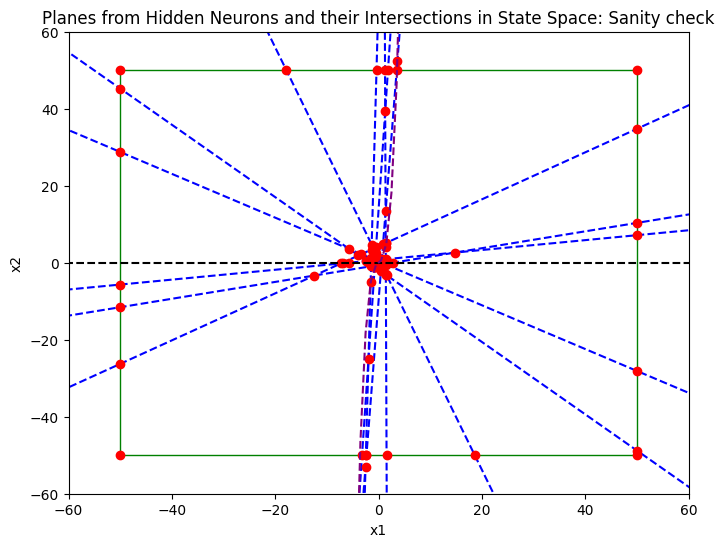

In [67]:
#Now get the weights like we did in my_result, this is for the planes
W_matrix  = duffing_nn.network[0].weight.detach().numpy().T
B_vector  = duffing_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = duffing_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]


#find a rectangle that contains all the intersection points, these are vertices too
#REGION OF INTEREST
x1_min = -50
x1_max = 50
x2_min = -50
x2_max = 50
intersection_points = find_all_intersection_points(W_matrix, B_vector, [duffing_f1_boundary, duffing_f2_boundary], x1_min, x1_max, x2_min, x2_max)


#okay sweet now we have all the intersection points, which will act as the vertex set for the planar graph 
#use a dictionary for vertex set, since each vertex has a location
vertex_set = {}
for i in range(len(intersection_points)):
    v_str = f'v{i}'
    vertex_set[v_str] = intersection_points[i]
#The string version is just for printing the graph in python library 

#now make the edge set
#for each vertex, loop through the plane functions and edge functions of the rectangle and find which nodes are the neighbors
edge_list  = []
for i in range(len(intersection_points)):
    this_vertex = intersection_points[i]
    for j in range(len(intersection_points)):
        if(i != j): #make sure not the same nodes (you'll get they are neighbors)
            this_other_vertex = intersection_points[j]
            neighbor_or_not = neighbor_finder(this_vertex, this_other_vertex, W_matrix, B_vector)
            if(neighbor_or_not): #if true, then add it to edge list
                v_str_1 = f'v{i}'
                v_str_2 = f'v{j}'
                this_edge = (v_str_1, v_str_2)
                edge_list.append(this_edge)

#so that is the edges who are connected to each other 
#but now we need to add the edges that come from the rectangle sides
#loop through each vertex and see if it is on the rectangle edge, if so find its neighbors on that edge
for i in range(len(intersection_points)):
    this_vertex = intersection_points[i]
    x1_coord = this_vertex[0]
    x2_coord = this_vertex[1]
    #check if on left edge
    if(abs(x1_coord - x1_min) < 1e-6):
        #then find neighbors on this edge
        for j in range(len(intersection_points)):
            if(i != j):
                this_other_vertex = intersection_points[j]
                if(abs(this_other_vertex[0] - x1_min) < 1e-6):
                    #then they are neighbors
                    v_str_1 = f'v{i}'
                    v_str_2 = f'v{j}'
                    this_edge = (v_str_1, v_str_2)
                    edge_list.append(this_edge)
    #check if on right edge
    if(abs(x1_coord - x1_max) < 1e-6):
        #then find neighbors on this edge
        for j in range(len(intersection_points)):
            if(i != j):
                this_other_vertex = intersection_points[j]
                if(abs(this_other_vertex[0] - x1_max) < 1e-6):
                    #then they are neighbors
                    v_str_1 = f'v{i}'
                    v_str_2 = f'v{j}'
                    this_edge = (v_str_1, v_str_2)
                    edge_list.append(this_edge)
    #check if on bottom edge
    if(abs(x2_coord - x2_min) < 1e-6):
        #then find neighbors on this edge
        for j in range(len(intersection_points)):
            if(i != j):
                this_other_vertex = intersection_points[j]
                if(abs(this_other_vertex[1] - x2_min) < 1e-6):
                    #then they are neighbors
                    v_str_1 = f'v{i}'
                    v_str_2 = f'v{j}'
                    this_edge = (v_str_1, v_str_2)
                    edge_list.append(this_edge)
    #check if on top edge
    if(abs(x2_coord - x2_max) < 1e-6):
        #then find neighbors on this edge
        for j in range(len(intersection_points)):
            if(i != j):
                this_other_vertex = intersection_points[j]
                if(abs(this_other_vertex[1] - x2_max) < 1e-6):
                    #then they are neighbors
                    v_str_1 = f'v{i}'
                    v_str_2 = f'v{j}'
                    this_edge = (v_str_1, v_str_2)
                    edge_list.append(this_edge)



print(edge_list)
print(vertex_set)
#plot the regions in R2 defined by all of the planes from the hidden neurons
x1 = np.linspace(-500, 500, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(W_matrix.shape[1]):
    w_i = W_matrix[:, i]
    b_i = B_vector[i]
    x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
    ax.plot(x1, x2_plane, color='blue', linestyle='--', linewidth=1.5, label=f'Neuron {i+1} Boundary')

    
#plot intersection pts
for i in range(len(intersection_points)):
    # ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
    ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
#plot the rectangle containing all the intersection points
rect = plt.Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min, linewidth=1, edgecolor='green', facecolor='none', label='Intersection Region')
ax.add_patch(rect)
ax.set_xlim(x1_min -10, x1_max + 10)
ax.set_ylim(x2_min - 10, x2_max + 10)
#also plot the dynamics boundary of positive and negative
f1_boundary = 0
f2_boundary = duffing_f2_boundary(x1)
ax.plot(x1, f1_boundary * np.ones_like(x1), color='black', linestyle='--', linewidth=1.5, label='$f_1 = 0$')
ax.plot(x1, f2_boundary, color='purple', linestyle='--', linewidth=1.5, label='$f_2 = 0$')
plt.title('Planes from Hidden Neurons and their Intersections in State Space: Sanity check')
plt.xlabel("x1")
plt.ylabel("x2")



Plane y=0x+-20 intersects at (2.5917, -20.0000)
Plane y=2x+5 intersects at (-1.1542, 2.6917)
Plane y=-1x+10 intersects at (-2.1544, 12.1544)
